# The Bloq Counts Protocol

`Bloq.bloq_counts(ssa)` is a protocol that queries the number of each distinct subbloq in the parent bloq's decomposition. This can be derived from the full decomposition or annotated directly by overriding the `bloq_counts` method.

In [1]:
from qualtran.resource_counting import get_bloq_counts_graph, print_counts_graph, \
    GraphvizCounts, markdown_counts_graph, markdown_counts_sigma, SympySymbolAllocator

## Basic counts graph of `And`

In [2]:
from qualtran.bloqs.and_bloq import MultiAnd, And

graph, sigma = get_bloq_counts_graph(MultiAnd(cvs=(1,)*6))
print_counts_graph(graph)

MultiAnd(cvs=(1, 1, 1, 1, 1, 1), adjoint=False) -- 5 -> And(cv1=1, cv2=1, adjoint=False)
And(cv1=1, cv2=1, adjoint=False) -- 9 -> ArbitraryClifford(n=2)
And(cv1=1, cv2=1, adjoint=False) -- 4 -> TGate()


In [3]:
markdown_counts_graph(graph)

 - `MultiAnd(cvs=(1, 1, 1, 1, 1, 1), adjoint=False)`
   - `MultiAnd(cvs=(1, 1, 1, 1, 1, 1), adjoint=False)`: $\displaystyle 5$
 - `And(cv1=1, cv2=1, adjoint=False)`
   - `And(cv1=1, cv2=1, adjoint=False)`: $\displaystyle 9$
   - `And(cv1=1, cv2=1, adjoint=False)`: $\displaystyle 4$


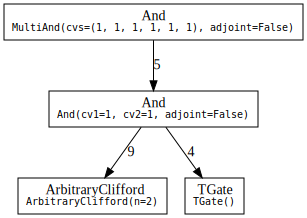

In [4]:
GraphvizCounts(graph).get_svg()

In [5]:
markdown_counts_sigma(sigma)

 - `ArbitraryClifford(n=2)`: 45
 - `TGate()`: 20

## Importance of bloq generalization

Often, bloqs have attributes that are important for describing their specific action but don't affect the bloq's resource cost. For example, `Rx(0.12)` and `Rx(0.13)` should probably be considered equal when counting the number of operations. Another example is given below where we group all two-bit `And` operations no matter their control values. 

`get_bloq_counts_graph` takes an optional callable that takes specific bloqs to general bloqs. See below for an example of what happens to the `MultiAnd` counts graph without generalization, and how we can use it to replace specific control values with sympy symbols.

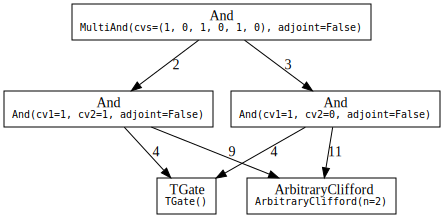

In [6]:
graph, sigma = get_bloq_counts_graph(MultiAnd(cvs=(1,0)*3))
GraphvizCounts(graph).get_svg()

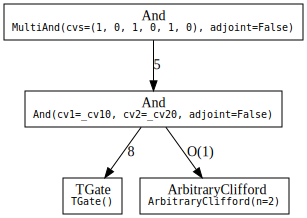

In [7]:
import attrs

ssa = SympySymbolAllocator()
cv1 = ssa.new_symbol('cv1')
cv2 = ssa.new_symbol('cv2')


def generalize(bloq):
    if isinstance(bloq, And):
        return attrs.evolve(bloq, cv1=cv1, cv2=cv2)
    
    return bloq

graph, sigma = get_bloq_counts_graph(MultiAnd(cvs=(1,0)*3), generalize, ssa)
GraphvizCounts(graph).get_svg()

In [8]:
markdown_counts_sigma(sigma)

 - `TGate()`: 20
 - `ArbitraryClifford(n=2)`: $\displaystyle O\left(1\right)$